# DEEP FAKE DETECTOR
by GLEM

Eleonora Marcassa - 900571

Giuseppe Massidda - 901029

Lorenzo Muscillo - 1000916

Manuel Trevisan - 886937

## First Part


#### Packages




In [1]:
!pip install pathos

import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np

from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
import time
from pathos.multiprocessing import ProcessingPool as Pool
from multiprocessing import cpu_count
import json
import random
import sys

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00


In [2]:
# If you are working from Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This can make the training faster as you are storing the file in local on colab, so you can use the 100% power of the GPU/TPU

# !unzip "/content/drive/MyDrive/Colab Notebooks/DF-DCT/Processed_data.zip"
!unzip "/content/drive/MyDrive/Colab Notebooks/DF-DCT/Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Validation/Real/real_5499.jpg  
  inflating: Validation/Real/real_55.jpg  
  inflating: Validation/Real/real_550.jpg  
  inflating: Validation/Real/real_5500.jpg  
  inflating: Validation/Real/real_5501.jpg  
  inflating: Validation/Real/real_5502.jpg  
  inflating: Validation/Real/real_5503.jpg  
  inflating: Validation/Real/real_5504.jpg  
  inflating: Validation/Real/real_5505.jpg  
  inflating: Validation/Real/real_5506.jpg  
  inflating: Validation/Real/real_5507.jpg  
  inflating: Validation/Real/real_5508.jpg  
  inflating: Validation/Real/real_5509.jpg  
  inflating: Validation/Real/real_551.jpg  
  inflating: Validation/Real/real_5510.jpg  
  inflating: Validation/Real/real_5511.jpg  
  inflating: Validation/Real/real_5512.jpg  
  inflating: Validation/Real/real_5513.jpg  
  inflating: Validation/Real/real_5514.jpg  
  inflating: Validation/Real/real_5515.jpg  
  inflating: Validation/Real/real_5516.jpg  
  inflat

### CNN IMAGES


#### Importing the dataset

Firstly, we started from images: the aim is to build a CNN that can classify fake and real images.

The dataset contains three folders:
1. *Train* - 140k videos;
2. *Validation* - 40k videos;
3. *Test* - 10k videos.

Each one of these folders contains 50% Real-50% Fake videos.

Our images are 256x256 pixels.

We took our dataset from: https://zenodo.org/records/5528418#.YpdlS2hBzDd

In [ ]:
# Insert the directory
data_dir = r"/content/Dataset"

In [ ]:
os.listdir(data_dir)

['Validation', 'Test', 'Train']

In [ ]:
print(len( os.listdir((os.path.join(data_dir,'Train','Real')))))
print(len( os.listdir((os.path.join(data_dir,'Train','Fake')))))

70001
70001


In [ ]:
for image_class in os.listdir((os.path.join(data_dir,'Train','Real'))):
  print(image_class)
  break

real_0.jpg


In [ ]:
img = cv2.imread(os.path.join(data_dir,'Train','Real','real_0.jpg'))

In [ ]:
type(img)

numpy.ndarray

In [ ]:
img.shape

(256, 256, 3)

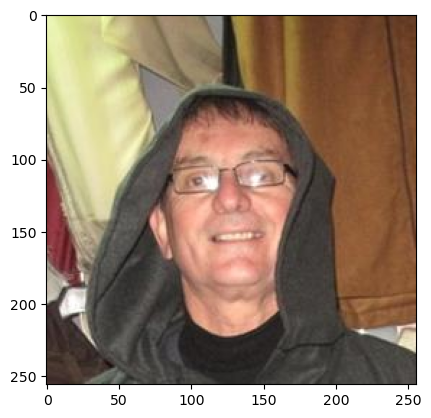

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### Creating train and validation directories

In [ ]:
train_direct = data_dir + "/Train"
train_data = tf.keras.utils.image_dataset_from_directory(train_direct)

data_iterator = train_data.as_numpy_iterator()

batch = data_iterator.next()

print(len(batch))
print(batch[0].shape)
print(batch[1])

Found 140002 files belonging to 2 classes.
2
(32, 256, 256, 3)
[1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0]


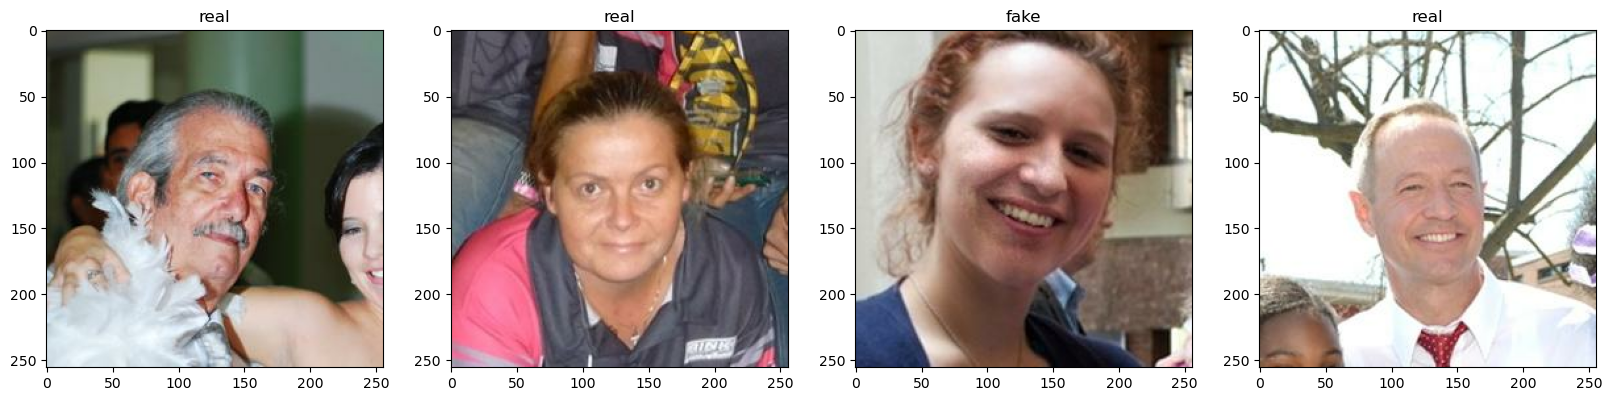

In [ ]:
# plotting few random images belonging to the dataset
ig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    if batch[1][idx] == 0:
        title = "fake"
    else:
        title = "real"
    ax[idx].title.set_text(title)

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_direct,
    image_size=(256, 256),
    batch_size=32,
    seed=123
)

Found 140002 files belonging to 2 classes.


In [ ]:
val_direct = data_dir + "/Validation"

val_data = tf.keras.utils.image_dataset_from_directory(
    val_direct,
    image_size=(256, 256),
    batch_size=32,
    seed=123
)

Found 39428 files belonging to 2 classes.


### The very first CNN - made by us
At first, we created a very simple CNN, in order to test our dataset and understand how it works. After some adjustments, we managed to obtain some good results.

At the very beginning, we tried to include some data augmentation process, which resulted useless as it worsen the results.

In [ ]:
# Add this in the sequential model before the CNN
    # # Data Augmentation
    # layers.RandomFlip("horizontal_and_vertical"),
    # layers.RandomRotation(0.2, fill_mode = "nearest"),
    # layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomTranslation(0.2, 0.2),

So, our model is composed by four convulational layers: each of them followed by a maxpooling layer and a dropout layer with a dropout rate of 10%, except for the last one. The ReLU function is used in every layer as the activation function.

The last convolution layer is followed up by a flatten layer. A dense layer is added, which is followed up by a dropout layer with a rate of 25%.

The very last layer is the output layer, in which the activation function is a sigmoid function.

In [4]:
model = models.Sequential([
    # Preprocessing
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),

    # CNN

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25), # Dropout layer with 25% rate
    layers.Dense(1, activation='sigmoid')
])
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,233,985 (50.48 MB)

 Trainable params: 13,233,985 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [ ]:

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.keras',
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch')


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 231s 53ms/step - accuracy: 0.7705 - loss: 0.4637 - val_accuracy: 0.8480 - val_loss: 0.3415
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 225s 51ms/step - accuracy: 0.9230 - loss: 0.1858 - val_accuracy: 0.9212 - val_loss: 0.1885
Epoch 3/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 225s 51ms/step - accuracy: 0.9521 - loss: 0.1196 - val_accuracy: 0.9320 - val_loss: 0.1645
Epoch 4/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 225s 51ms/step - accuracy: 0.9644 - loss: 0.0897 - val_accuracy: 0.9394 - val_loss: 0.1528
Epoch 5/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 226s 52ms/step - accuracy: 0.9731 - loss: 0.0675 - val_accuracy: 0.9354 - val_loss: 0.1999
Epoch 6/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 225s 52ms/step - accuracy: 0.9792 - loss: 0.0550 - val_accuracy: 0.9478 - val_loss: 0.1614
Epoch 7/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 225s 51ms/step - accuracy: 0.9848 - loss: 0.0399 - val_accuracy: 0.9452 - val_loss: 0.2073
Epoch 8/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 225s 51ms/step - accuracy: 

#### Testing


In [8]:
test_data = tf.keras.utils.image_dataset_from_directory(
    data_dir + "\Test",
    image_size=(256, 256),
    batch_size=32,
    shuffle = False,
    seed=123
)

Found 10905 files belonging to 2 classes.


In [9]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/DF-DCT/model_epoch_03.keras')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9161 - loss: 0.2032
Test Loss: 0.34711480140686035
Test Accuracy: 0.855295717716217


#### Classification report

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary (0 or 1)

# Assuming you have the true labels
y_true = np.concatenate([y for x, y in test_data], axis=0)

# Confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Confusion Matrix:
[[5132  360]
 [1218 4195]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      5492
           1       0.92      0.77      0.84      5413

    accuracy                           0.86     10905
   macro avg       0.86      0.85      0.85     10905
weighted avg       0.86      0.86      0.85     10905



In [ ]:
print(f"y_true shape: {y_true.shape}, y_pred_classes shape: {y_pred_classes.shape}")
print(f"y_true type: {type(y_true)}, y_pred_classes type: {type(y_pred_classes)}")

y_true shape: (10905,), y_pred_classes shape: (10905, 1)
y_true type: <class 'numpy.ndarray'>, y_pred_classes type: <class 'numpy.ndarray'>


In [ ]:
print("Sample Predictions and True Labels:")
for i in range(10):
    print(f"True Label: {y_true[i]}, Predicted: {y_pred_classes[i]}")

Sample Predictions and True Labels:
True Label: 1, Predicted: [1]
True Label: 1, Predicted: [1]
True Label: 1, Predicted: [0]
True Label: 1, Predicted: [1]
True Label: 0, Predicted: [0]
True Label: 0, Predicted: [1]
True Label: 0, Predicted: [0]
True Label: 1, Predicted: [0]
True Label: 0, Predicted: [1]
True Label: 0, Predicted: [1]


In [ ]:
unique, counts = np.unique(y_true, return_counts=True)
print("Class distribution in y_true:", dict(zip(unique, counts)))

Class distribution in y_true: {0: 5492, 1: 5413}


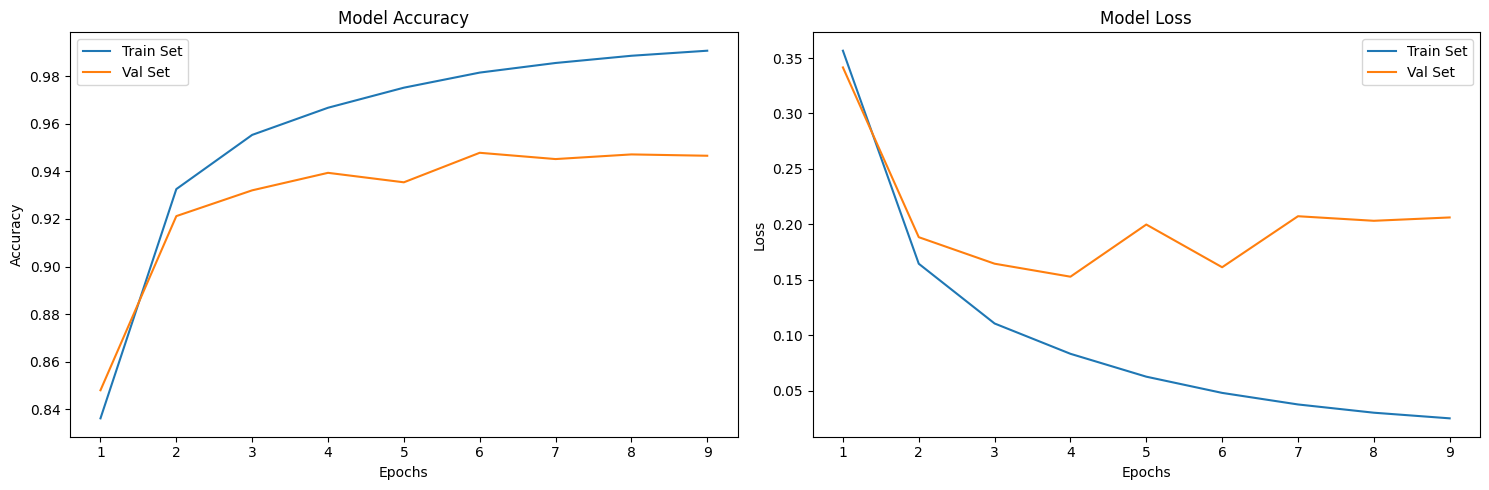

In [ ]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Set')
plt.plot(epochs, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Set')
plt.plot(epochs, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

plt.tight_layout()
plt.show()

### INCEPTIONV3

Curious to know whether we could get better results or not from our CNN, we decided to try other already existing models: *e.g.* VGG16, Meso4, ResNet50V2, EfficientNetB2 and InceptionV3.

In particular, this last model, which has been used by D. Güera and E. J. Delp and shown in their paper *"Deepfake Video Detection Using Recurrent Neural Networks"*, is the one that gave us the best results among all the others aforementioned.

However, we early discovered that it was too expensive in terms of time and reasources involved in it, despite the promising results it delivered.

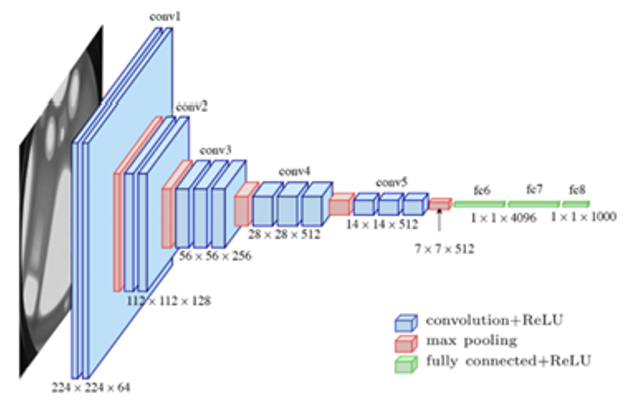

In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Clear any existing TensorFlow session
tf.keras.backend.clear_session()

# Recreate the model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Data generators for training and validation

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    data_dir + "/Train",
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    data_dir + "/Validation",
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Training
checkpoint = ModelCheckpoint(
    filepath='/content/DeepFake-Dct/Checkpoints/Epoch_lore/CNNV3_model_epoch_{epoch:02d}.keras',
    save_freq='epoch'
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=2, # For acceptable results, run at least 10 epochs
    callbacks=[checkpoint])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 127, 127, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 127, 127, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 125, 125, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 125, 125, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 125, 125, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 62, 62, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 62, 62, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 62, 62, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,903,010 (91.18 MB)

 Trainable params: 23,868,578 (91.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1614s 348ms/step - accuracy: 0.9400 - loss: 0.1537 - val_accuracy: 0.9154 - val_loss: 0.1947
Epoch 2/2
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1473s 336ms/step - accuracy: 0.9743 - loss: 0.0658 - val_accuracy: 0.9634 - val_loss: 0.0985


In [ ]:
#For us, the ninth epoch yielded the best results.
model.load_weights('/content/drive/MyDrive/Colab Notebooks/DF-DCT/Inception V3/CNNV3_model_epoch_09.keras')

loss, accuracy = model.evaluate(test_data)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.9046 - loss: 0.4563
Test Loss: 0.4639233350753784
Test Accuracy: 0.9033470749855042


## Second Part
### VIDEO CLASSIFICATION

#### Importing the dataset using data generators

As our aim is to identify wether an image is fake or not, in this second part we implement videos in our model.

The dataset contains three folders:
1. *Train - 14k videos*;
2. *Validation - 3k videos*;
3. *Test - 3k videos*.

Each one of these folders contains 50% Real-50% Fake videos

Videos are 256x256 pixels.

You can find the dataset at the following link: https://github.com/huangjiadidi/DeepFakeMnist

In [ ]:
# Parameters
VIDEO_WIDTH, VIDEO_HEIGHT = 64, 64 # Downscaling the video for efficiency
MAX_FRAMES = 20  # Number of frames of a video that will be fed to the model as one sequence
BATCH_SIZE = 32

DATASET_DIR = "Video Dataset Small"
PROCESSED_DIR = "Video Dataset Small\\Processed_data"
CLASSES = ["fake", "real"]

#### Pre-processing data

One of the main challenges we faced while working with videos was the dimensionality of the objects involved. In order to feed data into our model, we need a fast but compact solution. Initially, we tried to create objects that stored all the data required for training. However, this approach resulted impractical due to RAM limitations.

Next, we tried using data generators that extract data "on-the-fly" with a batch-by-batch approach. For sure, this method is lighter on RAM, but it slows down the model during runtime.

So, in order to speed up things, our final approach involves preprocessing the data beforehand: this speeds up training by minimizing the time spent loading and processing videos during each epoch.

**Note**: YOU DON'T NEED TO RUN THE FOLLOWING CELL unless your "Video Dataset Small/Processed_data" folder is empty or you want to change parameters in the chunk above.

In [ ]:
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        return np.zeros((MAX_FRAMES, VIDEO_HEIGHT, VIDEO_WIDTH, 3))

    frames_to_sample = min(MAX_FRAMES, total_frames)
    frame_indices = np.linspace(0, total_frames - 1, frames_to_sample, dtype=int)

    frames = []
    for frame_index in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (VIDEO_WIDTH, VIDEO_HEIGHT))
            frame = frame / 255.0  # Normalize pixel values
            frames.append(frame)
        else:
            frames.append(np.zeros((VIDEO_HEIGHT, VIDEO_WIDTH, 3)))

    cap.release()

    # Pad with zeros if we couldn't extract enough frames
    if len(frames) < MAX_FRAMES:
        padding = [np.zeros((VIDEO_HEIGHT, VIDEO_WIDTH, 3)) for _ in range(MAX_FRAMES - len(frames))]
        frames.extend(padding)

    return np.array(frames[:MAX_FRAMES])

def process_dataset():
    for subset in ['Train', 'Val', 'Test']:
        for class_name in ['real', 'fake']:
            input_dir = os.path.join(DATASET_DIR, subset, class_name)
            output_dir = os.path.join(PROCESSED_DIR, subset, class_name)
            os.makedirs(output_dir, exist_ok=True)

            video_files = [f for f in os.listdir(input_dir) if f.endswith('.mp4')]

            for video_file in tqdm(video_files, desc=f"Processing {subset} {class_name}"):
                video_path = os.path.join(input_dir, video_file)
                processed_frames = preprocess_video(video_path)

                output_path = os.path.join(output_dir, video_file.replace('.mp4', '.npy'))
                np.save(output_path, processed_frames)

if __name__ == "__main__":
    process_dataset()

Processing Test fake: 100%|██████████| 1500/1500 [02:56<00:00,  8.51it/s]


In [ ]:
# Data Loader

class VideoDataGenerator(Sequence):
    def __init__(self, data_dir, subset, batch_size=BATCH_SIZE):
        self.data_dir = data_dir
        self.subset = subset
        self.batch_size = batch_size
        self.classes = ['real', 'fake']
        self.videos = self._get_video_paths()
        self.on_epoch_end()

    def _get_video_paths(self):
        videos = []
        subset_dir = os.path.join(self.data_dir, self.subset)
        for class_name in self.classes:
            class_dir = os.path.join(subset_dir, class_name)
            for video_name in os.listdir(class_dir):
                if video_name.endswith('.npy'):
                    videos.append((os.path.join(class_dir, video_name), self.classes.index(class_name)))
        return videos

    def __len__(self):
        return len(self.videos) // self.batch_size

    def __getitem__(self, idx):
        batch_videos = self.videos[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_frames = []
        batch_labels = []

        for video_path, label in batch_videos:
            frames = np.load(video_path)
            batch_frames.append(frames)
            batch_labels.append(label)

        return np.array(batch_frames), np.array(batch_labels)

    def on_epoch_end(self):
        np.random.shuffle(self.videos)


train_generator = VideoDataGenerator(PROCESSED_DIR, "Train")
val_generator = VideoDataGenerator(PROCESSED_DIR, "Val")
test_generator = VideoDataGenerator(PROCESSED_DIR, "Test")

### CREATING THE MODEL


#### CNN

Even if we were already getting nice results from our very first CNN - which is previously shown in the first part - we decided to make it simpler. Unexpectedly, we obtain even better results than before. (Nice indeed!)

In [ ]:
CNN_model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, (5, 5), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),

    layers.Flatten(),

    layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
])

#### LSTM

So far, we just focused on CNNs. Now that videos are involved, it's time to introduce something new!

We used a TimeDistributed layer to feed all the frames from each video to the CNN, followed by an LSTM approach to extract features from the whole wc
video.

With a couple of additional layers, this setup performed really well. However, making the model overly complex led to overfitting. So, once again, we opt for simplicity: a simpler architecture prove to be the best choice so far.

In [ ]:
CNN_LSTM_model = models.Sequential()

CNN_LSTM_model.add(layers.Input((MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3))) # 3 are the channels

CNN_LSTM_model.add(layers.TimeDistributed(CNN_model))

CNN_LSTM_model.add(layers.LSTM(128, return_sequences=False))
CNN_LSTM_model.add(layers.Dense(128, activation='relu'))
CNN_LSTM_model.add(layers.Dropout(0.1))
CNN_LSTM_model.add(layers.Dense(32, activation='relu'))
CNN_LSTM_model.add(layers.Dropout(0.25))
CNN_LSTM_model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

CNN_LSTM_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

CNN_LSTM_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 256)        │       466,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,001 (2.61 MB)

 Trainable params: 684,001 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.keras',
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch')

history = CNN_LSTM_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[checkpoint_callback])

# Saving the history on a JSON file in order to not loose the results
with open('history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/40


c:\Users\megam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


437/437 ━━━━━━━━━━━━━━━━━━━━ 302s 652ms/step - accuracy: 0.5198 - loss: 0.7172 - val_accuracy: 0.6324 - val_loss: 0.6407
Epoch 2/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 178s 405ms/step - accuracy: 0.6967 - loss: 0.5843 - val_accuracy: 0.8659 - val_loss: 0.3252
Epoch 3/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 169s 384ms/step - accuracy: 0.8778 - loss: 0.3046 - val_accuracy: 0.9278 - val_loss: 0.1959
Epoch 4/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 172s 392ms/step - accuracy: 0.9371 - loss: 0.1756 - val_accuracy: 0.9425 - val_loss: 0.1718
Epoch 5/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 171s 389ms/step - accuracy: 0.9563 - loss: 0.1280 - val_accuracy: 0.9694 - val_loss: 0.1038
Epoch 6/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 170s 387ms/step - accuracy: 0.9658 - loss: 0.0992 - val_accuracy: 0.9748 - val_loss: 0.0816
Epoch 7/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 168s 382ms/step - accuracy: 0.9751 - loss: 0.0770 - val_accuracy: 0.9765 - val_loss: 0.0884
Epoch 8/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 167s 378ms/step - accuracy: 0.9817 - loss: 0.06

### Evaluation

In [ ]:
# Evaluating the model
test_loss, test_accuracy = CNN_LSTM_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step - accuracy: 0.9859 - loss: 0.0630
Test Loss: 0.07000903785228729
Test Accuracy: 0.9845430254936218


In [ ]:
# Loading different epochs to see wich is better
model_path = 'Best Model/model_epoch_40(Manu).keras'
CNN_LSTM_model.load_weights(model_path)

# Evaluating the model
test_loss, test_accuracy = CNN_LSTM_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.9892 - loss: 0.0693
Test Loss: 0.08829152584075928
Test Accuracy: 0.9872311949729919


#### Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
for i, (_, labels) in enumerate(test_generator):
    if len(labels) < BATCH_SIZE: # Just to be shure
        break
    y_true.extend(labels.flatten())
y_true = np.array(y_true)

# Confusion matrix
y_pred = CNN_LSTM_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=CLASSES)
print("Classification Report:")
print(report)

93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step
Confusion Matrix:
[[1452   33]
 [   4 1487]]
Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.98      0.99      1485
        real       0.98      1.00      0.99      1491

    accuracy                           0.99      2976
   macro avg       0.99      0.99      0.99      2976
weighted avg       0.99      0.99      0.99      2976



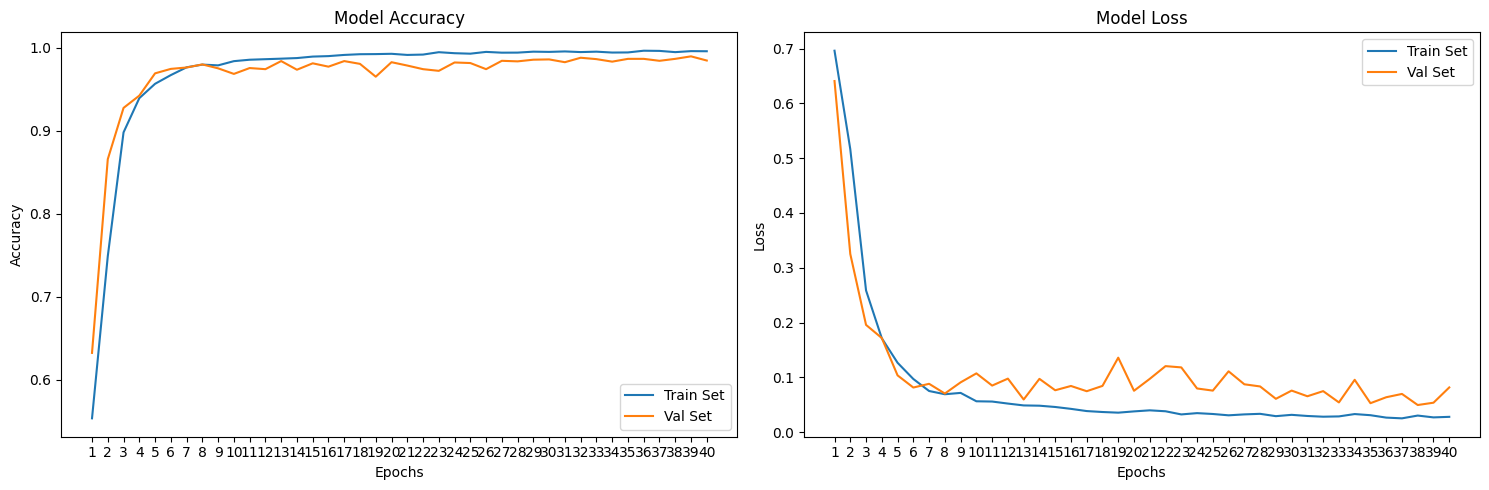

In [ ]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Set')
plt.plot(epochs, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Set')
plt.plot(epochs, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

plt.tight_layout()
plt.show()

## Third Part
### A PyTorch APPROACH

Just for the sake of knowledge, we replicated all the previously explained processes using PyTorch.

### Training a CNN on images

The images dataset we used previously will be used to train a convolutional neural network. The parameters resulting from this training will be inserted into a larger model that resembles the CNN-LSTM that we made previously to detect deepfake videos.

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn

IMG_DATA_BATCH_SIZE = 64
DEVICE = "cuda"
CLASS_THRESHOLD = 0.5
LR = 0.0001

#### Image preprocessing

the images in the Dataset are 256x256 pixels, but the videos we are classifying with the LSTM will be preprocessed to be 64x64. For this reason, the CNN as well will be trained on images 64x64. The following code will resize the dataset and prepare the dataloader object to train the CNN

In [ ]:
import torch
from torchvision.io import read_image
from torchvision.transforms.functional import resize
import os
from tqdm import tqdm

def resize_image(img_path):
    img = read_image(img_path)
    return resize(img, size = [64,64])

def resize_dataset(output_dir):
    for subset in ['Train', 'Validation', 'Test']:
        for class_name in ['real', 'fake']:
            input_dir = os.path.join("Dataset", subset, class_name)
            new_output_dir = os.path.join(output_dir, subset, class_name)
            os.makedirs(new_output_dir, exist_ok=True)

            img_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]

            for img_file in tqdm(img_files, desc=f"Processing {subset} {class_name}"):
                video_path = os.path.join(input_dir, img_file)
                processed_image = resize_image(video_path)

                output_path = os.path.join(new_output_dir, img_file.replace('.jpg', '.pth'))
                torch.save(processed_image, output_path)

# resize_dataset("..\\resized_images")

In [ ]:
class ImageDataset(Dataset):

    def __init__(self, processed_dir = "../resized_images", subset = "Train", batch_size = IMG_DATA_BATCH_SIZE, device = DEVICE):
        self.directory = processed_dir+"/"+subset
        self.batch_size = batch_size
        self.device = device
        self.images = self._get_img_paths()
        self._shuffle_data()
        self.length = int(len(self.images)/self.batch_size) + 1

    def _get_img_paths(self):
        imgs = []
        for img_path in os.listdir(self.directory + "/Fake"):
            imgs.append((self.directory + "/Fake/"+img_path, 1))
        for img_path in os.listdir(self.directory + "/Real"):
            imgs.append((self.directory + "/Real/"+img_path, 0))
        return imgs

    def _shuffle_data(self):
        np.random.shuffle(self.images)

    def __getitem__(self,index):
        images = []
        labels = []
        for img, label in self.images[index*self.batch_size:(index+1)*self.batch_size]:
            labels.append(label)
            images.append(torch.load(img)/256)
            x = torch.stack(images).to(self.device)
            y = torch.tensor(labels).to(self.device).to(torch.float32)
        return x, y

    def __len__(self):
        return self.length


val_img_dataset = ImageDataset(subset="Validation", batch_size= IMG_DATA_BATCH_SIZE, device = DEVICE)
train_img_dataset = ImageDataset(subset="Train", batch_size= IMG_DATA_BATCH_SIZE, device = DEVICE)

val_img_loader = DataLoader(val_img_dataset, batch_size= None, collate_fn= lambda x: x)
train_img_loader = DataLoader(train_img_dataset, batch_size= None, collate_fn= lambda x: x)

#### Training/validation loop


In [ ]:
def train_loop(model, epochs, train_loader, val_loader, class_threshold = CLASS_THRESHOLD):

    history = dict()

    for e in range(1,epochs+1):

        model.train()
        print("-"*40+f"|EPOCH {e}|"+"-"*40)
        losses = []
        for batch, (x,y) in tqdm(enumerate(train_loader),desc = "Training loop"):
            pred_proba, _ = model(x)
            loss_value = model.loss_function(pred_proba,y)
            losses.append(loss_value.item())
            loss_value.backward()
            model.optimizer_function.step()
            model.optimizer_function.zero_grad()
        print(f"Train Loss: {np.mean(losses):.5f} | Progress: [{batch+1}/{len(train_loader)}]")
        history[f"train_loss_epoch_{e}"] = losses

        model.eval()
        loss, correct, val_size = 0,0,0
        with torch.no_grad():
             for x,y in tqdm(val_loader, desc= "Validation Loop"):
                  val_size += y.shape[0]
                  pred_proba, _ = model(x)
                  loss += model.loss_function(pred_proba,y)
                  pred_class = (pred_proba > class_threshold).type(torch.float)
                  correct += (pred_class == y).type(torch.float).sum().item()
        val_accuracy = correct/val_size
        print(f"Validation Accuracy {(val_accuracy):.2%} | Validation Loss {(loss/len(val_loader)):6f} | Train Loss {np.mean(losses):.5f}")
        history[f"val_loss_epoch_{e}"] = loss.item()
        history[f"val_accuracy_epoch_{e}"] = val_accuracy

        train_loader.dataset._shuffle_data()
        val_loader.dataset._shuffle_data()

    for key, value in history.items():
        if isinstance(value, list):
            history[key] = np.mean(value).item()

    return history

#### Model

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class DF_img_detector(nn.Module):

    def __init__(self, sequence, final_layer,
                 loss_function,
                 optimizer_constructor,
                 optimizer_kwargs = {"lr": LR}):
        super(DF_img_detector, self).__init__()
        self.sequence = sequence
        self.final_layer = final_layer
        self.loss_function = loss_function
        self.optimizer_function = optimizer_constructor(self.parameters(),**optimizer_kwargs)
        self.to(DEVICE)

    def forward(self, x):
        embedding = self.sequence(x)
        p_hat = self.final_layer(embedding)
        return p_hat.flatten(), embedding

sequence = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels= 16, kernel_size= 3, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels= 32, kernel_size= 3, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels= 64, kernel_size= 5, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.1)
)

final_layer = nn.Sequential(
    nn.Linear(256,1),
    nn.Sigmoid()
)

pretrained_cnn = DF_img_detector(sequence= sequence, final_layer= final_layer,
                          loss_function= nn.BCELoss(),
                          optimizer_constructor= torch.optim.Adam)

print("number of parameter: ",count_parameters(model_0))
for name, param in model_0.named_parameters():
    print(f'{name}: {param.dtype}, params: {param.numel()}')

number of parameter:  466465
sequence.0.weight: torch.float32, params: 432
sequence.0.bias: torch.float32, params: 16
sequence.4.weight: torch.float32, params: 4608
sequence.4.bias: torch.float32, params: 32
sequence.8.weight: torch.float32, params: 51200
sequence.8.bias: torch.float32, params: 64
sequence.13.weight: torch.float32, params: 409600
sequence.13.bias: torch.float32, params: 256
final_layer.0.weight: torch.float32, params: 256
final_layer.0.bias: torch.float32, params: 1


#### Training the model

In [ ]:
history = train_loop(pretrained_cnn, epochs= 15,
           train_loader= train_img_loader,
           val_loader=val_img_loader)
# torch.save(pretrained_cnn, 'pytorch models/pretrainedCNN_15_e.pth')

----------------------------------------|EPOCH 1|----------------------------------------


Training loop: 2188it [18:16,  2.00it/s]


Train Loss: 0.49018 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [05:23<00:00,  1.90it/s]


Validation Accuracy 77.62% | Validation Loss 0.489452 | Train Loss 0.49018
----------------------------------------|EPOCH 2|----------------------------------------


Training loop: 2188it [17:23,  2.10it/s]


Train Loss: 0.38577 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [02:00<00:00,  5.10it/s]


Validation Accuracy 81.31% | Validation Loss 0.434585 | Train Loss 0.38577
----------------------------------------|EPOCH 3|----------------------------------------


Training loop: 2188it [02:19, 15.65it/s]


Train Loss: 0.32875 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:38<00:00, 16.17it/s]


Validation Accuracy 83.59% | Validation Loss 0.375817 | Train Loss 0.32875
----------------------------------------|EPOCH 4|----------------------------------------


Training loop: 2188it [02:14, 16.28it/s]


Train Loss: 0.29240 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:37<00:00, 16.33it/s]


Validation Accuracy 85.27% | Validation Loss 0.340825 | Train Loss 0.29240
----------------------------------------|EPOCH 5|----------------------------------------


Training loop: 2188it [02:15, 16.20it/s]


Train Loss: 0.26701 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:37<00:00, 16.57it/s]


Validation Accuracy 86.44% | Validation Loss 0.320467 | Train Loss 0.26701
----------------------------------------|EPOCH 6|----------------------------------------


Training loop: 2188it [02:15, 16.17it/s]


Train Loss: 0.24681 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:38<00:00, 16.15it/s]


Validation Accuracy 87.67% | Validation Loss 0.306132 | Train Loss 0.24681
----------------------------------------|EPOCH 7|----------------------------------------


Training loop: 2188it [02:17, 15.96it/s]


Train Loss: 0.23112 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:35<00:00, 17.27it/s]


Validation Accuracy 87.14% | Validation Loss 0.296283 | Train Loss 0.23112
----------------------------------------|EPOCH 8|----------------------------------------


Training loop: 2188it [02:16, 16.03it/s]


Train Loss: 0.21992 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:38<00:00, 15.90it/s]


Validation Accuracy 88.72% | Validation Loss 0.273309 | Train Loss 0.21992
----------------------------------------|EPOCH 9|----------------------------------------


Training loop: 2188it [09:40,  3.77it/s]


Train Loss: 0.20777 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [04:55<00:00,  2.09it/s]


Validation Accuracy 89.03% | Validation Loss 0.265127 | Train Loss 0.20777
----------------------------------------|EPOCH 10|----------------------------------------


Training loop: 2188it [10:54,  3.34it/s]


Train Loss: 0.19766 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:37<00:00, 16.37it/s]


Validation Accuracy 89.65% | Validation Loss 0.252307 | Train Loss 0.19766
----------------------------------------|EPOCH 11|----------------------------------------


Training loop: 2188it [02:05, 17.41it/s]


Train Loss: 0.18991 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:34<00:00, 17.75it/s]


Validation Accuracy 90.08% | Validation Loss 0.247084 | Train Loss 0.18991
----------------------------------------|EPOCH 12|----------------------------------------


Training loop: 2188it [02:07, 17.20it/s]


Train Loss: 0.18214 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:33<00:00, 18.25it/s]


Validation Accuracy 89.47% | Validation Loss 0.250494 | Train Loss 0.18214
----------------------------------------|EPOCH 13|----------------------------------------


Training loop: 2188it [02:05, 17.39it/s]


Train Loss: 0.17599 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:34<00:00, 17.75it/s]


Validation Accuracy 90.48% | Validation Loss 0.227125 | Train Loss 0.17599
----------------------------------------|EPOCH 14|----------------------------------------


Training loop: 2188it [02:04, 17.53it/s]


Train Loss: 0.16830 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:34<00:00, 17.93it/s]


Validation Accuracy 90.21% | Validation Loss 0.233873 | Train Loss 0.16830
----------------------------------------|EPOCH 15|----------------------------------------


Training loop: 2188it [02:07, 17.22it/s]


Train Loss: 0.16326 | Progress: [2188/2188]


Validation Loop: 100%|██████████| 617/617 [00:33<00:00, 18.39it/s]

Validation Accuracy 90.96% | Validation Loss 0.221887 | Train Loss 0.16326


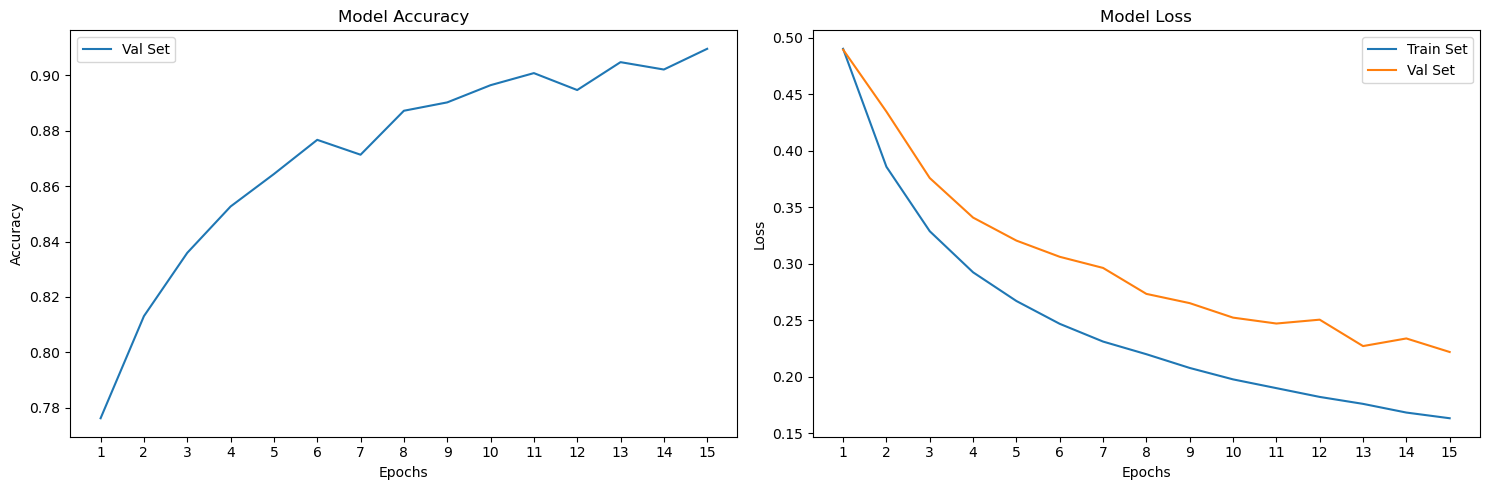

In [ ]:
train_loss = []
val_accuracy = []
val_loss = []

for key, value, in history.items():
    if key.startswith("train_loss"):
        train_loss.append(value)
    if key.startswith("val_loss"):
        val_loss.append(value/len(val_img_loader))
    if key.startswith("val_accuracy"):
        val_accuracy.append(value)

epochs = list(range(1,len(train_loss)+1))

import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])


# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Set')
plt.plot(epochs, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

plt.tight_layout()
plt.show()

#### Classification Report

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

pretrained_cnn.eval()
y_true = []
p_hats = []

with torch.no_grad():
    for x,y in tqdm(val_img_loader):
        p_hat, _ = pretrained_cnn(x)
        p_hats.append(p_hat.to("cpu"))
        y_true.append(y.to("cpu"))

y_true = torch.cat(y_true).numpy()
p_hats = torch.cat(p_hats).numpy()


100%|██████████| 617/617 [00:33<00:00, 18.32it/s]


In [ ]:
print(f"Validation accuracy: {accuracy_score(y_true, p_hats > 0.5)}")

print(f"Area under the curve of validation set: {roc_auc_score(y_true, p_hats)}")

print("Confusion matrix on validation set with threshold 0.5\n",confusion_matrix(y_true,  p_hats > 0.5))

print("Classification Report on validation set, t = 0.5\n",classification_report(y_true, p_hats > 0.5))

Validation accuracy: 0.9096073856142842
Area under the curve of validation set: 0.9736174732156568
Confusion matrix on validation set with threshold 0.5
 [[18757  1030]
 [ 2534 17107]]
Classification Report on validation set, t = 0.5
               precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     19787
         1.0       0.94      0.87      0.91     19641

    accuracy                           0.91     39428
   macro avg       0.91      0.91      0.91     39428
weighted avg       0.91      0.91      0.91     39428



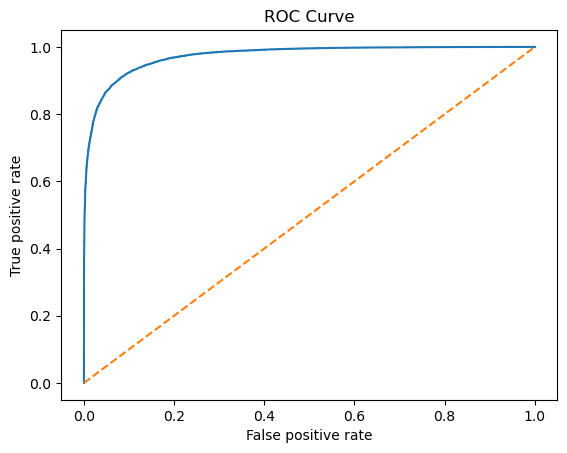

In [ ]:
fpr, tpr, t = roc_curve(y_true, p_hats)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], "--")
plt.title("ROC Curve")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.show()

#### LSTM network with pretrained CNN

Now we can build the LSTM network that takes as input the frames of a video embedded as the vector of size 256 produced by the CNN we just trained.


In [ ]:
PROCESSED_DIR = "../Processed_data"
DEVICE = "cuda"
BATCH_SIZE = 32

CLASS_THRESHOLD = 0.5

LR = 0.0001


#### Video Datasets and Dataloaders

In [ ]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, processed_dir = "../Processed_data", subset = "Train", batch_size = 32, device = "cuda"):
        self.directory = processed_dir+"/"+subset
        self.batch_size = batch_size
        self.subset = subset
        self.device = device

        self.videos = self._get_video_paths()
        self._shuffle_data()

        self.length = int(len(self.videos)/self.batch_size) + 1

    def _get_video_paths(self):
        videos = []
        for filename in os.listdir(self.directory + "/real"):
            if filename.endswith(".npy"):
                videos.append((self.directory + "/real/"+ filename,0))
        for filename in os.listdir(self.directory + "/fake"):
            if filename.endswith(".npy"):
                videos.append((self.directory + "/fake/"+ filename,1))
        return videos

    def _shuffle_data(self):
        np.random.shuffle(self.videos)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        #this function will return an array of the following shape:
        #(batch_size, n_frames, n_channels, height, width)
        # and a vector of length batch_size that indicates the
        # class: 0 for real videos, 1 for fake videos
        features = []
        targets = []
        for video_path, label in self.videos[index*self.batch_size:(index+1)*self.batch_size]:
            array = torch.from_numpy(np.load(video_path)).permute(0, 3, 1, 2).to(self.device).to(torch.float32)
            # To work with nn.Conv2d the dimension that indicates channels
            # #has to be the third one, not the last one
            features.append(array)
            targets.append(label)
        return torch.stack(features), torch.tensor(targets).to(self.device).to(torch.float32)


# dataset objects
video_train_dataset = VideoDataset(processed_dir = PROCESSED_DIR, subset= "Train", batch_size= BATCH_SIZE, device= DEVICE)
video_val_dataset = VideoDataset(processed_dir = PROCESSED_DIR, subset= "Val", batch_size= BATCH_SIZE, device= DEVICE)

# making the dataloader objects
# the parameters batch size and collate fn have to be this way, do not change them
video_train_dataloader = torch.utils.data.DataLoader(video_train_dataset, batch_size= None, collate_fn= lambda x: x)
video_val_dataloader = torch.utils.data.DataLoader(video_val_dataset, batch_size= None, collate_fn= lambda x: x)

#### Traning function and  Full Model

In [ ]:
def train_loop(model, epochs, train_loader, val_loader, class_threshold = CLASS_THRESHOLD):

    history = dict()

    for e in range(1,epochs+1):

        model.train()
        print("-"*40+f"|EPOCH {e}|"+"-"*40)
        losses = []
        for batch, (x,y) in tqdm(enumerate(train_loader),desc = "Training loop"):
            pred_proba = model(x)
            loss_value = model.loss_function(pred_proba,y)
            losses.append(loss_value.item())
            loss_value.backward()
            model.optimizer_function.step()
            model.optimizer_function.zero_grad()
        print(f"Train Loss: {np.mean(losses):.5f} | Progress: [{batch+1}/{len(train_loader)}]")
        history[f"train_loss_epoch_{e}"] = losses

        model.eval()
        loss, correct, val_size = 0,0,0
        with torch.no_grad():
             for x,y in tqdm(val_loader, desc= "Validation Loop"):
                  val_size += y.shape[0]
                  pred_proba = model(x)
                  loss += model.loss_function(pred_proba,y)
                  pred_class = (pred_proba > class_threshold).type(torch.float)
                  correct += (pred_class == y).type(torch.float).sum().item()
        print(f"Validation Accuracy {(correct/val_size):.2%} | Validation Loss {(loss/len(val_loader)):6f} | Train Loss {np.mean(losses):.5f}")
        history[f"val_loss_epoch_{e}"] = loss.item()
        history[f"val_correct_epoch_{e}"] = correct
        history[f"val_size_epoch_{e}"] = val_size

        train_loader.dataset._shuffle_data()
        val_loader.dataset._shuffle_data()

    for key, value in history.items():
        if isinstance(value, list):
            history[key] = np.mean(value).item()

    return history

In [ ]:
#freezing the parameters of the CNN so that they will not change when we train the other parameters

for param in pretrained_cnn.parameters():
    param.requires_grad = False

# defining the time distributed class
# returns an embedding for each temporal slice of the input

class TimeDistributed(nn.Module):
    '''
    This object takes a layer or a sequence of layers and applies it to each individual temporal slice of an input.
    It returns the embedding produced by the given layers for each temporal slice for each data point in the batch
    '''
    def __init__(self,layer):
        super(TimeDistributed,self).__init__()
        self.layer = layer

    def forward(self, x):
        batch_size, t_slices , *slice_dims = x.shape
        x = x.reshape(batch_size*t_slices, *slice_dims)
        p_hat, embedding = self.layer(x)
        output_batches, *embedding_shape = embedding.shape
        assert output_batches == batch_size * t_slices, f"Wrong Number of batches in the output: the layers inside TimeDistributed should output {batch_size * t_slices} batches, but got {output_batches} instead"
        embedding = embedding.reshape((batch_size, t_slices, *embedding_shape))
        p_hat = p_hat.reshape((batch_size, t_slices))
        return p_hat, embedding


# Defining the RNN that detects deepfake videos
class DeepFakeDetector(nn.Module):
    def __init__(self, cnn, rnn, sequence, loss_function,
                 optimizer_constructor,
                 optimizer_kwargs = {"lr": LR}):
        super(DeepFakeDetector, self).__init__()
        self.t_dist_cnn = TimeDistributed(cnn)
        self.rnn = rnn
        self.sequence = sequence
        self.loss_function = loss_function
        self.optimizer_function = optimizer_constructor(self.parameters(),**optimizer_kwargs)
        self.to(DEVICE)

    def forward(self, x):
        # input x has shape [batch_size, n_frames, n_channels, frame_H, frame_W]
        p_hat, embedded_frames = self.t_dist_cnn(x)

        self.rnn.flatten_parameters()
        #adding this line because it was giving a warning

        rnn_out, (h_n, c_n) = self.rnn(embedded_frames)
        # from the rnn we only take the final cell state

        pred_proba = self.sequence(c_n[-1,:, :])
        # a vector of length batch_size
        return pred_proba.flatten()


# defining the rnn that takes the output of time distributed cnn
rnn = nn.LSTM(input_size=256, hidden_size= 256,
              num_layers= 1, batch_first= True)

# now we can build the complete network

lstm_pretrained_cnn = DeepFakeDetector(cnn = pretrained_cnn, rnn = rnn,
                             sequence=nn.Sequential(
                                 nn.Linear(in_features=256, out_features=128),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(in_features=128, out_features=64),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(64,1),
                                 nn.Sigmoid()),
                             loss_function=nn.BCELoss(),
                             optimizer_constructor= torch.optim.Adam)


print("number of parameter: ",count_parameters(lstm_pretrained_cnn))

# Verify the data types of the parameters
for name, param in lstm_pretrained_cnn.named_parameters():
    print(f'{name}: {param.dtype}, params: {param.numel()}, require grad: {param.requires_grad}')


number of parameter:  567553
t_dist_cnn.layer.sequence.0.weight: torch.float32, params: 432, require grad: False
t_dist_cnn.layer.sequence.0.bias: torch.float32, params: 16, require grad: False
t_dist_cnn.layer.sequence.4.weight: torch.float32, params: 4608, require grad: False
t_dist_cnn.layer.sequence.4.bias: torch.float32, params: 32, require grad: False
t_dist_cnn.layer.sequence.8.weight: torch.float32, params: 51200, require grad: False
t_dist_cnn.layer.sequence.8.bias: torch.float32, params: 64, require grad: False
t_dist_cnn.layer.sequence.13.weight: torch.float32, params: 409600, require grad: False
t_dist_cnn.layer.sequence.13.bias: torch.float32, params: 256, require grad: False
t_dist_cnn.layer.final_layer.0.weight: torch.float32, params: 256, require grad: False
t_dist_cnn.layer.final_layer.0.bias: torch.float32, params: 1, require grad: False
rnn.weight_ih_l0: torch.float32, params: 262144, require grad: True
rnn.weight_hh_l0: torch.float32, params: 262144, require grad: T

#### Training the parameters of the LSTM

In [ ]:
history = train_loop(lstm_pretrained_cnn, epochs= 20,
           train_loader= video_train_dataloader,
           val_loader=video_val_dataloader)

----------------------------------------|EPOCH 1|----------------------------------------


Training loop: 438it [02:12,  3.30it/s]


Train Loss: 0.68260 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Validation Accuracy 57.47% | Validation Loss 0.671075 | Train Loss 0.68260
----------------------------------------|EPOCH 2|----------------------------------------


Training loop: 438it [00:52,  8.32it/s]


Train Loss: 0.63881 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Validation Accuracy 59.43% | Validation Loss 0.657745 | Train Loss 0.63881
----------------------------------------|EPOCH 3|----------------------------------------


Training loop: 438it [00:52,  8.38it/s]


Train Loss: 0.59692 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.61it/s]


Validation Accuracy 66.07% | Validation Loss 0.609859 | Train Loss 0.59692
----------------------------------------|EPOCH 4|----------------------------------------


Training loop: 438it [00:51,  8.51it/s]


Train Loss: 0.54822 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


Validation Accuracy 69.87% | Validation Loss 0.570031 | Train Loss 0.54822
----------------------------------------|EPOCH 5|----------------------------------------


Training loop: 438it [00:51,  8.54it/s]


Train Loss: 0.52070 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


Validation Accuracy 75.90% | Validation Loss 0.532416 | Train Loss 0.52070
----------------------------------------|EPOCH 6|----------------------------------------


Training loop: 438it [00:51,  8.47it/s]


Train Loss: 0.49064 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Validation Accuracy 76.73% | Validation Loss 0.504087 | Train Loss 0.49064
----------------------------------------|EPOCH 7|----------------------------------------


Training loop: 438it [00:51,  8.52it/s]


Train Loss: 0.45563 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.67it/s]


Validation Accuracy 73.40% | Validation Loss 0.518232 | Train Loss 0.45563
----------------------------------------|EPOCH 8|----------------------------------------


Training loop: 438it [00:50,  8.62it/s]


Train Loss: 0.41900 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.61it/s]


Validation Accuracy 76.00% | Validation Loss 0.479643 | Train Loss 0.41900
----------------------------------------|EPOCH 9|----------------------------------------


Training loop: 438it [00:50,  8.60it/s]


Train Loss: 0.39486 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.54it/s]


Validation Accuracy 76.37% | Validation Loss 0.485854 | Train Loss 0.39486
----------------------------------------|EPOCH 10|----------------------------------------


Training loop: 438it [00:52,  8.41it/s]


Train Loss: 0.37180 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.45it/s]


Validation Accuracy 80.03% | Validation Loss 0.435747 | Train Loss 0.37180
----------------------------------------|EPOCH 11|----------------------------------------


Training loop: 438it [00:51,  8.47it/s]


Train Loss: 0.35346 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.57it/s]


Validation Accuracy 79.77% | Validation Loss 0.432034 | Train Loss 0.35346
----------------------------------------|EPOCH 12|----------------------------------------


Training loop: 438it [00:51,  8.57it/s]


Train Loss: 0.35101 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.62it/s]


Validation Accuracy 77.70% | Validation Loss 0.460706 | Train Loss 0.35101
----------------------------------------|EPOCH 13|----------------------------------------


Training loop: 438it [00:51,  8.52it/s]


Train Loss: 0.33911 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.51it/s]


Validation Accuracy 80.40% | Validation Loss 0.419412 | Train Loss 0.33911
----------------------------------------|EPOCH 14|----------------------------------------


Training loop: 438it [00:51,  8.45it/s]


Train Loss: 0.33214 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.50it/s]


Validation Accuracy 80.93% | Validation Loss 0.402371 | Train Loss 0.33214
----------------------------------------|EPOCH 15|----------------------------------------


Training loop: 438it [00:51,  8.58it/s]


Train Loss: 0.32387 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.52it/s]


Validation Accuracy 83.43% | Validation Loss 0.374401 | Train Loss 0.32387
----------------------------------------|EPOCH 16|----------------------------------------


Training loop: 438it [00:50,  8.62it/s]


Train Loss: 0.32034 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.50it/s]


Validation Accuracy 79.23% | Validation Loss 0.430951 | Train Loss 0.32034
----------------------------------------|EPOCH 17|----------------------------------------


Training loop: 438it [00:51,  8.54it/s]


Train Loss: 0.30937 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.49it/s]


Validation Accuracy 84.00% | Validation Loss 0.359464 | Train Loss 0.30937
----------------------------------------|EPOCH 18|----------------------------------------


Training loop: 438it [00:51,  8.45it/s]


Train Loss: 0.30720 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.64it/s]


Validation Accuracy 83.83% | Validation Loss 0.360996 | Train Loss 0.30720
----------------------------------------|EPOCH 19|----------------------------------------


Training loop: 438it [00:51,  8.52it/s]


Train Loss: 0.30133 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.68it/s]


Validation Accuracy 81.47% | Validation Loss 0.401142 | Train Loss 0.30133
----------------------------------------|EPOCH 20|----------------------------------------


Training loop: 438it [00:51,  8.57it/s]


Train Loss: 0.29809 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.63it/s]

Validation Accuracy 82.17% | Validation Loss 0.391939 | Train Loss 0.29809


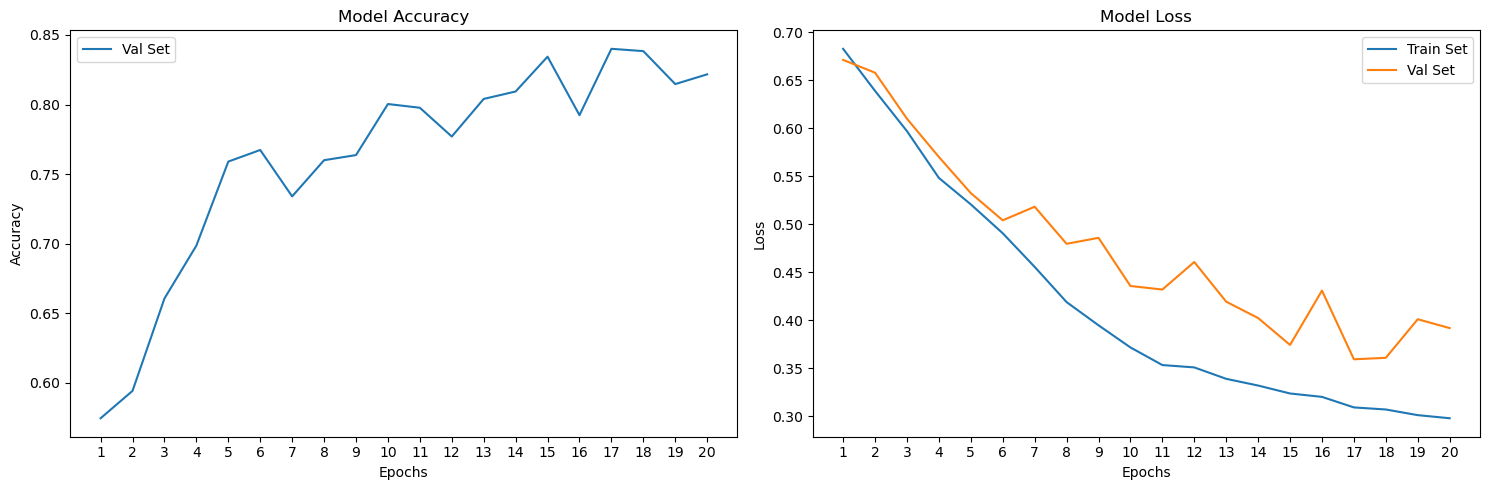

In [ ]:
train_loss = []
val_accuracy = []
val_loss = []

for key, value, in history.items():
    if key.startswith("train_loss"):
        train_loss.append(value)
    if key.startswith("val_loss"):
        val_loss.append(value/len(video_val_dataloader))
    if key.startswith("val_correct"):
        val_accuracy.append(value/3000)

epochs = list(range(1,len(train_loss)+1))

import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])


# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Set')
plt.plot(epochs, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

plt.tight_layout()
plt.show()

#### Classification Report

In [ ]:
lstm_pretrained_cnn.eval()
y_true = []
p_hats = []

with torch.no_grad():
    for x,y in tqdm(video_val_dataloader):
        p_hat= lstm_pretrained_cnn(x)
        p_hats.append(p_hat.to("cpu"))
        y_true.append(y.to("cpu"))


y_true = torch.cat(y_true).numpy()
p_hats = torch.cat(p_hats).numpy()

100%|██████████| 94/94 [00:05<00:00, 18.75it/s]


In [ ]:
print(f"Validation accuracy: {accuracy_score(y_true, p_hats > 0.5)}")

print(f"Area under the curve of validation set: {roc_auc_score(y_true, p_hats)}")

print("Confusion matrix on validation set with threshold 0.5\n",confusion_matrix(y_true,  p_hats > 0.5))

print("Classification Report on validation set, t = 0.5\n",classification_report(y_true, p_hats > 0.5))

Validation accuracy: 0.8216666666666667
Area under the curve of validation set: 0.9335244444444444
Confusion matrix on validation set with threshold 0.5
 [[1040  460]
 [  75 1425]]
Classification Report on validation set, t = 0.5
               precision    recall  f1-score   support

         0.0       0.93      0.69      0.80      1500
         1.0       0.76      0.95      0.84      1500

    accuracy                           0.82      3000
   macro avg       0.84      0.82      0.82      3000
weighted avg       0.84      0.82      0.82      3000



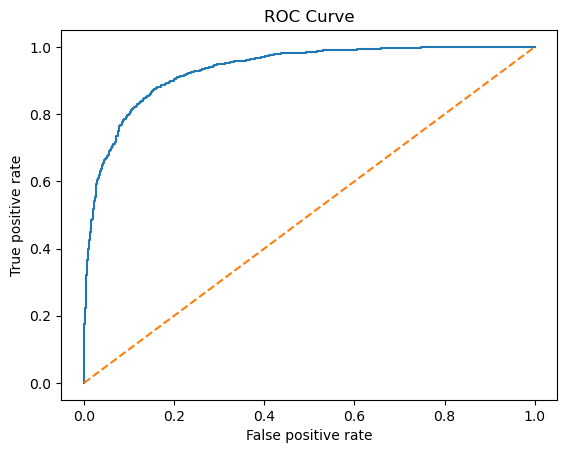

In [ ]:
fpr, tpr, t = roc_curve(y_true, p_hats)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], "--")
plt.title("ROC Curve")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.show()

This was an interesting approach, here is a summary.

The image dataset was used to train a CNN that detects deepfake images. The last dense layer of this CNN is a single neuron with a sigmoid activation function. This output neuron takes as input a vector with 256 components, which is the embedding of the image that the CNN is classifying.

The full model that is used to detect deepfake videos applies the CNN to each frame of the video that has been selected in preprocessing. Thus the input of the LSTM is two-dimensional: one dimension for the features (256) of the frame, and the other dimension for the temporal sequence of the frames (usually 20 or 40 equally spaced frames taken from a video of length between 4 and 15 seconds).

The parameters of the LSTM were trained after the parameters of the CNN, which were set to <code> require_grad = False</code> during the second training. The second training was done with the preprocessed videos dataset that we used in the second part of this notebook.

This approach produced a model that works well: the area under the curve on the validation set is higher than 0.95, indicating a good binary classifier. However it performs worse than the model in the second part which was trained entirely on the preprocessed videos.

In particular, we can see that this model tends to predict more positives (deepfakes). The confusion matrix with the naive 0.5 threshold on the validation set shows over 500 false positives but less than 40 false negatives.

We will try to replicate the more successfull approach used in the second part with the PyTorch framework.

### Training the CNN and the LSTM together on the videos


In [ ]:
# imports
import os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm


# Global variables

PROCESSED_DIR = "../../Processed_data"
DEVICE = "cuda"
BATCH_SIZE = 32

CLASS_THRESHOLD = 0.5

LR = 0.0001

#### Datasets, Dataloaders, and Training/Validation loops

In [ ]:
# Defining the dataset class
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, processed_dir = "../Processed_data", subset = "Train", batch_size = 32, device = "cuda"):
        self.directory = processed_dir+"/"+subset
        self.batch_size = batch_size
        self.subset = subset
        self.device = device

        self.videos = self._get_video_paths()
        self._shuffle_data()

        self.length = int(len(self.videos)/self.batch_size) + 1

    def _get_video_paths(self):
        videos = []
        for filename in os.listdir(self.directory + "/real"):
            if filename.endswith(".npy"):
                videos.append((self.directory + "/real/"+ filename,0))
        for filename in os.listdir(self.directory + "/fake"):
            if filename.endswith(".npy"):
                videos.append((self.directory + "/fake/"+ filename,1))
        return videos

    def _shuffle_data(self):
        np.random.shuffle(self.videos)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        #this function will return an array of the following shape:
        #(batch_size, n_frames, n_channels, height, width)
        # and a vector of length batch_size that indicates the
        # class: 0 for real videos, 1 for fake videos
        features = []
        targets = []
        for video_path, label in self.videos[index*self.batch_size:(index+1)*self.batch_size]:
            array = torch.from_numpy(np.load(video_path)).permute(0, 3, 1, 2).to(self.device).to(torch.float32)
            # To work with nn.Conv2d the dimension that indicates channels
            # #has to be the third one, not the last one
            features.append(array)
            targets.append(label)
        return torch.stack(features), torch.tensor(targets).to(self.device).to(torch.float32)


# dataset objects
train_dataset = VideoDataset(processed_dir = PROCESSED_DIR, subset= "Train", batch_size= BATCH_SIZE, device= DEVICE)
val_dataset = VideoDataset(processed_dir = PROCESSED_DIR, subset= "Val", batch_size= BATCH_SIZE, device= DEVICE)

# dataloader objects
# the parameters batch size and collate fn have to be this way, do not change them
# This is because the batches are generated by the dataset, not by the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= None, collate_fn= lambda x: x)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size= None, collate_fn= lambda x: x)

In [ ]:
def train_loop(model, epochs, train_loader, val_loader, class_threshold = CLASS_THRESHOLD):

    history = dict()
    for e in range(1,epochs+1):

        model.train()
        print("-"*40+f"|EPOCH {e}|"+"-"*40)
        losses = []
        for batch, (x,y) in tqdm(enumerate(train_loader),desc = "Training loop"):
            pred_proba = model(x)
            loss_value = model.loss_function(pred_proba,y)
            losses.append(loss_value.item())
            loss_value.backward()
            model.optimizer_function.step()
            model.optimizer_function.zero_grad()
        print(f"Train Loss: {np.mean(losses):.5f} | Progress: [{batch+1}/{len(train_loader)}]")
        history[f"train_loss_epoch_{e}"] = losses

        model.eval()
        loss, correct, val_size = 0,0,0
        with torch.no_grad():
             for x,y in tqdm(val_loader, desc= "Validation Loop"):
                  val_size += y.shape[0]
                  pred_proba = model(x)
                  loss += model.loss_function(pred_proba,y)
                  pred_class = (pred_proba > class_threshold).type(torch.float)
                  correct += (pred_class == y).type(torch.float).sum().item()
        print(f"Validation Accuracy {(correct/val_size):.2%} | Validation Loss {(loss/len(val_loader)):6f} | Train Loss {np.mean(losses):.5f}")
        history[f"val_loss_epoch_{e}"] = loss.item()
        history[f"val_correct_epoch_{e}"] = correct
        history[f"val_size_epoch_{e}"] = val_size

        train_loader.dataset._shuffle_data()
        val_loader.dataset._shuffle_data()

    for key, value in history.items():
        if isinstance(value, list):
            history[key] = np.mean(value).item()
    return history

#### Making the Network

In [ ]:
# defining the time distributed class
# returns an embedding for each temporal slice of the input

class TimeDistributed(nn.Module):
    '''
    This object takes a layer or a sequence of layers and applies it to each individual temporal slice of an input.
    It returns the embedding produced by the given layers for each temporal slice for each data point in the batch
    '''
    def __init__(self,layer):
        super(TimeDistributed,self).__init__()
        self.layer = layer

    def forward(self, x):
        batch_size, t_slices , *slice_dims = x.shape
        x = x.reshape(batch_size*t_slices, *slice_dims)
        y = self.layer(x)
        output_batches, *embedding_shape = y.shape
        assert output_batches == batch_size * t_slices, f"Wrong Number of batches in the output: the layers inside TimeDistributed should output {batch_size * t_slices} batches, but got {output_batches} instead"
        y = y.reshape((batch_size, t_slices, *embedding_shape))
        return y


# Defining the RNN that detects deepfake videos
class DeepFakeDetector(nn.Module):
    def __init__(self, cnn, rnn, sequence, loss_function,
                 optimizer_constructor,
                 optimizer_kwargs = {"lr": LR}):
        super(DeepFakeDetector, self).__init__()
        self.t_dist_cnn = TimeDistributed(cnn)
        self.rnn = rnn
        self.sequence = sequence
        self.loss_function = loss_function
        self.optimizer_function = optimizer_constructor(self.parameters(),**optimizer_kwargs)
        self.to(DEVICE)

    def forward(self, x):
        # input x has shape [batch_size, n_frames, n_channels, frame_H, frame_W]
        embedded_frames = self.t_dist_cnn(x)

        self.rnn.flatten_parameters()
        rnn_out, (h_n, c_n) = self.rnn(embedded_frames)
        # from the rnn we only take the output at the last temporal slice

        pred_proba = self.sequence(rnn_out[:, -1, :])
        # a vector of length batch_size
        return pred_proba.flatten()


# defining the CNN that will return the embedding of each frame
# it will have an input of shape (batch_size * n_frames, 3 channels, 64 H, 64 W)
# it will output a tensor of shape(batch_size * n_frames, 256)

cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels= 16, kernel_size= 3, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels= 32, kernel_size= 3, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels= 64, kernel_size= 5, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.1)
)

# defining the rnn that takes the output of time distributed cnn
rnn = nn.LSTM(input_size=256, hidden_size= 64,
              num_layers= 1, batch_first= True)

# making the deepfake detector object

model_v01 = DeepFakeDetector(cnn = cnn, rnn = rnn,
                             sequence=nn.Sequential(
                                 nn.Linear(in_features=64, out_features=64),
                                 nn.ReLU(),
                                 nn.Dropout(0.25),
                                 nn.Linear(64,1),
                                 nn.Sigmoid()),
                             loss_function=nn.BCELoss(),
                             optimizer_constructor= torch.optim.Adam)

#function to count parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("number of parameter: ",count_parameters(model_v01))

for name, param in model_v01.named_parameters():
    print(f'{name}: {param.dtype}, params: {param.numel()}')

number of parameter:  552865
t_dist_cnn.layer.0.weight: torch.float32, params: 432
t_dist_cnn.layer.0.bias: torch.float32, params: 16
t_dist_cnn.layer.4.weight: torch.float32, params: 4608
t_dist_cnn.layer.4.bias: torch.float32, params: 32
t_dist_cnn.layer.8.weight: torch.float32, params: 51200
t_dist_cnn.layer.8.bias: torch.float32, params: 64
t_dist_cnn.layer.13.weight: torch.float32, params: 409600
t_dist_cnn.layer.13.bias: torch.float32, params: 256
rnn.weight_ih_l0: torch.float32, params: 65536
rnn.weight_hh_l0: torch.float32, params: 16384
rnn.bias_ih_l0: torch.float32, params: 256
rnn.bias_hh_l0: torch.float32, params: 256
sequence.0.weight: torch.float32, params: 4096
sequence.0.bias: torch.float32, params: 64
sequence.3.weight: torch.float32, params: 64
sequence.3.bias: torch.float32, params: 1


In [ ]:
history = train_loop(model_v01, epochs= 20,
           train_loader= train_dataloader,
           val_loader=val_dataloader)

# torch.save(model_v01, 'pytorch models/rnn_20_e.pth')

----------------------------------------|EPOCH 1|----------------------------------------


Training loop: 438it [02:15,  3.24it/s]


Train Loss: 0.68595 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


Validation Accuracy 56.30% | Validation Loss 0.683177 | Train Loss 0.68595
----------------------------------------|EPOCH 2|----------------------------------------


Training loop: 438it [00:57,  7.62it/s]


Train Loss: 0.65595 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.67it/s]


Validation Accuracy 58.37% | Validation Loss 0.666779 | Train Loss 0.65595
----------------------------------------|EPOCH 3|----------------------------------------


Training loop: 438it [00:57,  7.62it/s]


Train Loss: 0.58538 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Validation Accuracy 71.70% | Validation Loss 0.564299 | Train Loss 0.58538
----------------------------------------|EPOCH 4|----------------------------------------


Training loop: 438it [00:57,  7.57it/s]


Train Loss: 0.42070 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.22it/s]


Validation Accuracy 75.83% | Validation Loss 0.480504 | Train Loss 0.42070
----------------------------------------|EPOCH 5|----------------------------------------


Training loop: 438it [00:56,  7.80it/s]


Train Loss: 0.27444 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.12it/s]


Validation Accuracy 83.80% | Validation Loss 0.359938 | Train Loss 0.27444
----------------------------------------|EPOCH 6|----------------------------------------


Training loop: 438it [00:56,  7.72it/s]


Train Loss: 0.19364 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.85it/s]


Validation Accuracy 88.37% | Validation Loss 0.277283 | Train Loss 0.19364
----------------------------------------|EPOCH 7|----------------------------------------


Training loop: 438it [00:56,  7.73it/s]


Train Loss: 0.14888 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.24it/s]


Validation Accuracy 89.53% | Validation Loss 0.245513 | Train Loss 0.14888
----------------------------------------|EPOCH 8|----------------------------------------


Training loop: 438it [00:56,  7.81it/s]


Train Loss: 0.11994 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.27it/s]


Validation Accuracy 89.30% | Validation Loss 0.255800 | Train Loss 0.11994
----------------------------------------|EPOCH 9|----------------------------------------


Training loop: 438it [00:56,  7.77it/s]


Train Loss: 0.10005 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.32it/s]


Validation Accuracy 92.90% | Validation Loss 0.175260 | Train Loss 0.10005
----------------------------------------|EPOCH 10|----------------------------------------


Training loop: 438it [00:56,  7.73it/s]


Train Loss: 0.08205 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.03it/s]


Validation Accuracy 94.37% | Validation Loss 0.156814 | Train Loss 0.08205
----------------------------------------|EPOCH 11|----------------------------------------


Training loop: 438it [00:56,  7.81it/s]


Train Loss: 0.06677 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.00it/s]


Validation Accuracy 92.63% | Validation Loss 0.187830 | Train Loss 0.06677
----------------------------------------|EPOCH 12|----------------------------------------


Training loop: 438it [00:56,  7.82it/s]


Train Loss: 0.05574 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.11it/s]


Validation Accuracy 94.43% | Validation Loss 0.150236 | Train Loss 0.05574
----------------------------------------|EPOCH 13|----------------------------------------


Training loop: 438it [00:56,  7.72it/s]


Train Loss: 0.05020 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.95it/s]


Validation Accuracy 88.43% | Validation Loss 0.310001 | Train Loss 0.05020
----------------------------------------|EPOCH 14|----------------------------------------


Training loop: 438it [00:56,  7.71it/s]


Train Loss: 0.04154 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.03it/s]


Validation Accuracy 92.93% | Validation Loss 0.192677 | Train Loss 0.04154
----------------------------------------|EPOCH 15|----------------------------------------


Training loop: 438it [00:56,  7.74it/s]


Train Loss: 0.03656 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  9.09it/s]


Validation Accuracy 94.97% | Validation Loss 0.140220 | Train Loss 0.03656
----------------------------------------|EPOCH 16|----------------------------------------


Training loop: 438it [00:59,  7.40it/s]


Train Loss: 0.02974 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.39it/s]


Validation Accuracy 95.53% | Validation Loss 0.112271 | Train Loss 0.02974
----------------------------------------|EPOCH 17|----------------------------------------


Training loop: 438it [01:12,  6.01it/s]


Train Loss: 0.03171 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:13<00:00,  7.18it/s]


Validation Accuracy 93.93% | Validation Loss 0.160098 | Train Loss 0.03171
----------------------------------------|EPOCH 18|----------------------------------------


Training loop: 438it [01:00,  7.21it/s]


Train Loss: 0.02321 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.64it/s]


Validation Accuracy 96.00% | Validation Loss 0.110049 | Train Loss 0.02321
----------------------------------------|EPOCH 19|----------------------------------------


Training loop: 438it [00:57,  7.58it/s]


Train Loss: 0.02200 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.63it/s]


Validation Accuracy 94.93% | Validation Loss 0.139116 | Train Loss 0.02200
----------------------------------------|EPOCH 20|----------------------------------------


Training loop: 438it [00:58,  7.44it/s]


Train Loss: 0.01792 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.89it/s]

Validation Accuracy 96.73% | Validation Loss 0.099268 | Train Loss 0.01792


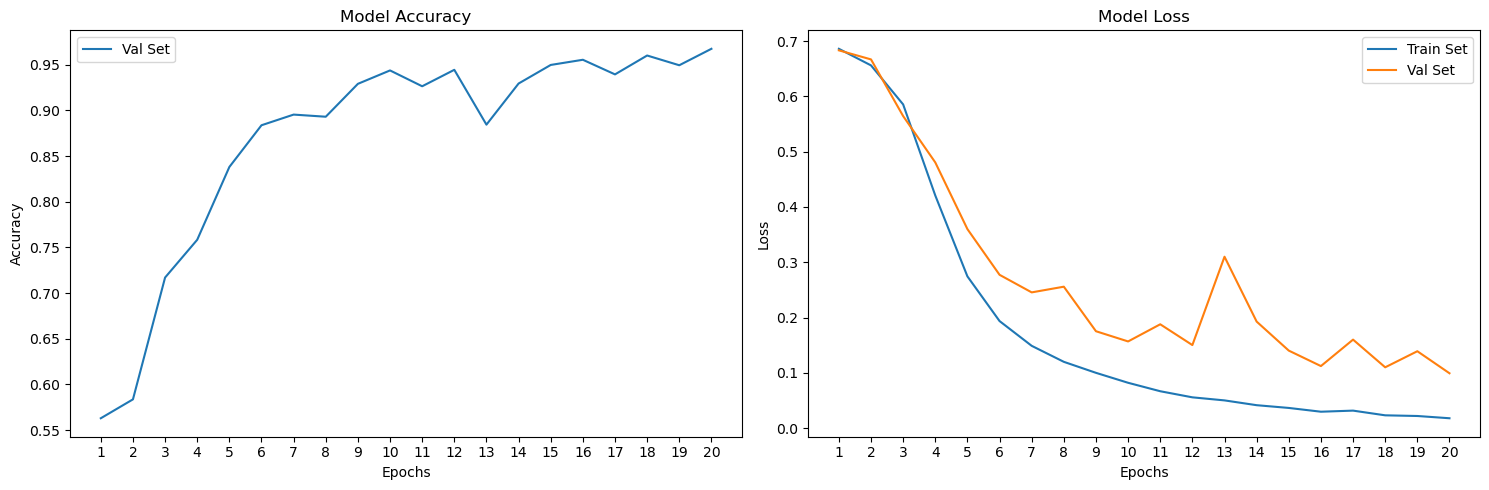

In [ ]:
train_loss = []
val_accuracy = []
val_loss = []

for key, value, in history.items():
    if key.startswith("train_loss"):
        train_loss.append(value)
    if key.startswith("val_loss"):
        val_loss.append(value/len(val_dataloader))
    if key.startswith("val_correct"):
        val_accuracy.append(value/3000)

epochs = list(range(1,len(train_loss)+1))

import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])


# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Set')
plt.plot(epochs, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

plt.tight_layout()
plt.show()

#### Classification report


In [ ]:
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# model_v01 = torch.load("pytorch models/rnn_pytorch_20_e.pth")

In [ ]:
model_v01.eval()
y_true = []
p_hats = []

with torch.no_grad():
    for x,y in tqdm(val_dataloader):
        p_hat = model_v01(x)
        p_hats.append(p_hat.to("cpu"))
        y_true.append(y.to("cpu"))

y_true = torch.cat(y_true).numpy()
p_hats = torch.cat(p_hats).numpy()


100%|██████████| 94/94 [00:05<00:00, 17.10it/s]


In [ ]:
print(f"Validation accuracy: {accuracy_score(y_true, p_hats > 0.5)}")

print(f"Area under the curve of validation set: {roc_auc_score(y_true, p_hats)}")

print("Confusion matrix on validation set with threshold 0.5\n",confusion_matrix(y_true,  p_hats > 0.5))

print("Classification Report on validation set, t = 0.5\n",classification_report(y_true, p_hats > 0.5))

Validation accuracy: 0.9673333333333334
Area under the curve of validation set: 0.9938391111111111
Confusion matrix on validation set with threshold 0.5
 [[1422   78]
 [  20 1480]]
Classification Report on validation set, t = 0.5
               precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      1500
         1.0       0.95      0.99      0.97      1500

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



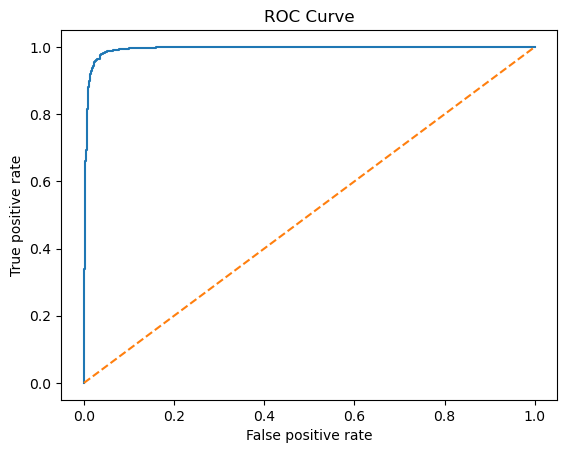

In [ ]:
fpr, tpr, t = roc_curve(y_true, p_hats)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], "--")
plt.title("ROC Curve")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.show()

## Our repository

You can find the datset and other results at the following link: https://github.com/LoreJob/DeepFake-Dct